# Fixing up a house in Louisiana

I think there are a lot fewer laws than in NYC, but it's (probably) tough.

**Topics:**

* PDF to CSV
* Secret APIs
* Scraping or regex
* Data cleaning

## Arborists `4 points`

If you need someone to cut down a tree, you might need an arborist!

* Fortunately, Louisiana has [a list of them](https://www.ldaf.state.la.us/ldaf-programs/horticulture-programs/louisiana-horticulture-commission/).
* Unfortunately [it's a PDF](http://www.ldaf.state.la.us/wp-content/uploads/2021/08/ARL-LIST-080421.pdf).
* the original PDF link has expiered. The new one is: https://www.ldaf.state.la.us/wp-content/uploads/2021/12/ARL-LIST-12012021.pdf

### Downloading the PDF using requests

In [178]:
import requests
user_agent = "scrapping_script/1.0"
headers = {'User-Agent': user_agent}
URL = "https://www.ldaf.state.la.us/wp-content/uploads/2021/12/ARL-LIST-12012021.pdf"
r = requests.get(URL, headers=headers, stream = True)
with open("arborists.pdf", "wb") as fd:
    fd.write(r.content)

### Convert the PDF to a CSV file or dataframe

In [160]:
import camelot
import matplotlib.pyplot as plt
import pandas as pd

tables = camelot.read_pdf("arborists.pdf", flavor='stream', pages='1-end')

<ipython-input-166-e6cb0c020545>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='contour').show()  #Alternativen sind 'grid' und 'contour' und


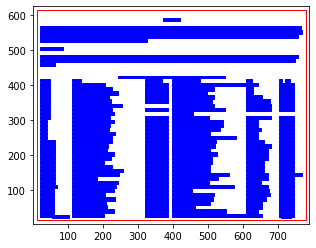

In [166]:
camelot.plot(tables[0], kind='contour').show()  #Alternativen sind 'grid' und 'contour' und

In [390]:
tabelle1 = camelot.read_pdf('arborists.pdf', flavor='stream', table_areas=['0,420,800,30'], columns=['103,305,395,600,698,709'], split_text=False)
tabelle2 = camelot.read_pdf("arborists.pdf", flavor='stream', pages='2-end',table_areas=['0,600,800,30'], columns=['103,305,395,600,698,709'], split_text=False)

In [388]:
tabelle1[0].df.head()

,0,1,2,3,4,5,6
0,Parish,Name,Bus Phone,Place of Business,City,St,Zip
1,Acadia,"BROUSSARD, LISA C",(337) 783-9390,GERALD'S LANDSCAPE & LAWN SERVICE LLC MORSE,,LA 70559,
2,Acadia,"DUPRE, ADAM ANTHONY",(337) 580-1021,ADTEK ENTERPRISES LLC,IOTA,LA 70543,
3,Acadia,"HARGRAVE, DOUGLAS LEON",(337) 523-6123,DOUGLAS HARGRAVE,IOTA,LA 70543,
4,Acadia,"LELEUX, CHARLOTTE R",(337) 784-0035,LELEUX'S CUT & HAUL LLC,CROWLEY,LA 70526,


In [415]:
x3[x3['Place of Business'].str.contains('GERALD')]

,Parish,Name,Bus Phone,Place of Business,City,St,Zip
1,Acadia,"Broussard, Lisa C",(337) 783-9390,GERALD'S LANDSCAPE & LAWN SERVICE LLC MORSE,Morse,LA,70559


In [409]:
import re as re
import numpy as np

# Die unterschiedlichen Seiten des PDF in einen einzigen Dataframe packen
x1 = tabelle1[0].df
dfs = [table.df for table in tabelle2]
x2 = pd.concat(dfs, ignore_index=True)
x3 = pd.concat([x1,x2], ignore_index=True)

# Die erste Zeile als Index festlegen
x3.columns = x3.iloc[0] 
x3 = x3[1:]

# Alle Werte aus 'St' auch in 'Zip' kopieren und umgekehrt
j = 1
k = 1
for cell in x3['St']:
    if cell != '':
        x3.loc[j].at['Zip'] = cell
    j = j + 1 
    
for cell in x3['Zip']:
    if cell != '':
        x3.loc[k].at['St'] = cell
    k = k + 1

# Buchstaben und Zahlen dort löschen, wo sie nicht hingehören
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
x3['Zip']=x3['Zip'].apply(lambda x: find_number(x))

def find_text(text):
    let = re.findall(r'[a-zA-z]+',text)
    return " ".join(let)
x3['St']=x3['St'].apply(lambda x: find_text(x))

# Green Fehler ausbessern
x3.loc[
    x3.St.str.contains('GREEN', na=False),
    "City"
] = 'GREENWELL SPRINGS'
x3.loc[
    x3.St.str.contains('GREEN', na=False),
    "St"
] = 'LA'

# Morse Fehler ausbessern
x3.loc[
    x3['Place of Business'].str.contains('MORSE', na=False),
    "City"
] = 'Morse'


# Groß- und Kleinschreibung richtigstellen
x3['Name']=x3['Name'].str.title()
x3['Place of Business']=x3['Place of Business'].str.upper()
x3['City']=x3['City'].str.title()

# Als CSV Datei speichern
x3.to_csv('arborists.csv')
x3

,Parish,Name,Bus Phone,Place of Business,City,St,Zip
1,Acadia,"Broussard, Lisa C",(337) 783-9390,GERALD'S LANDSCAPE & LAWN SERVICE LLC MORSE,Morse,LA,70559
2,Acadia,"Dupre, Adam Anthony",(337) 580-1021,ADTEK ENTERPRISES LLC,Iota,LA,70543
3,Acadia,"Hargrave, Douglas Leon",(337) 523-6123,DOUGLAS HARGRAVE,Iota,LA,70543
4,Acadia,"Leleux, Charlotte R",(337) 784-0035,LELEUX'S CUT & HAUL LLC,Crowley,LA,70526
5,Acadia,"Mouton, Mary Louise",(337) 250-0226,DARBY'S TREE SERVICE,Churchpoint,LA,70525
...,...,...,...,...,...,...,...
673,West Baton Rouge,"Prejean, Jeremy Paul",(225) 445-5568,MARMAK ENTERPRISES LLC,Port Allen,LA,70767
674,West Carroll,"Harrison, Jacob Glenn",(318) 884-6011,HARRISON TREE SERVICE,Oak Grove,LA,71263
675,West Feliciana,"Spinks, James T",(225) 635-3840,"SPINKS CONSTRUCTION, INC.",St. Francisville,LA,70775
676,Winn,"Allen, Don",(318) 268-1565,DON ALLEN LOGGING,Bradley,AR,71826


### Get me a list of every arborists in Shreveport

In [414]:
x3[x3['City'] == 'Shreveport']

,Parish,Name,Bus Phone,Place of Business,City,St,Zip
54,Bossier,"Atkins Iii, Reginald B",(318) 208-2589,ATKINS TREE SERVICE,Shreveport,LA,71107
55,Bossier,"Atkins Jr, Reginald B",(318) 208-2589,ATKINS TREE SERVICE,Shreveport,LA,71107
56,Bossier,"Atkins, Randall Kennon",(318) 208-2589,ATKINS TREE SERVICE,Shreveport,LA,71107
57,Bossier,"Atkins, Sandra B",(318) 208-2589,ATKINS TREE SERVICE,Shreveport,LA,71107
61,Bossier,"Davis, Richard L",(318) 673-6330,CITY OF SHREVEPORT,Shreveport,LA,71103
63,Bossier,"Floyd, Scottie W",,US LAWNS,Shreveport,LA,71105
64,Bossier,"Hutchinson, Clinton Hoyt",(318) 458-3141,MOOSE'S TREE SERVICE,Shreveport,LA,71107
75,Caddo,"Barron, Jack E",(318) 686-6950,BARRON'S TREE SERVICE,Shreveport,LA,71136
77,Caddo,"Davenport, Timothy",(318) 676-8822,LAWN TECH WEED & FERTILIZATION CO,Shreveport,LA,71107
78,Caddo,"Figlio, Gregory Michael",(318) 218-7449,FIGLIO TREE SERVICE LLC,Shreveport,LA,71115


## Contractors `2 points`

We skipped the arborists and tore down the tree. Unfortunately it landed on our house! So now we need a contractor to fix it up. Luckily there's an [easy contractor search page](https://lslbc.louisiana.gov/contractor-search/search-type-contractor/) on the Louisiana governemnt website.

### Get me a list of all residential roofing contractors

Convert it to a dataframe, save it as a CSV. Note that you **won't be scraping** for this one. You might *start* it as scraping, but you'll find an API.

In [132]:
import requests
import pandas as pd

user_agent = "scrapping_script/1.0"
headers = {'User-Agent': user_agent}

URL = 'https://lslbc.louisiana.gov/wp-admin/admin-ajax.php?api_action=advanced&contractor_type=Residential+License&classification=3966&action=api_actions'
response = requests.get(URL, headers=headers, stream = True).json()

response = response['results']

In [133]:
contractors = pd.DataFrame(response)
contractors.to_csv('residential_roofing_contractors.csv')
contractors

,city,company_name,id,qualifying_party,state
0,Baton Rouge,"A. S. Gomez, Inc.",259104,None,LA
1,Ponchatoula,Absolute Roofing & Exteriors of Louisiana LLC,321399,None,LA
2,Houston,"Acadian Roofing, LLC",298888,None,TX
3,Covington,"ALL AROUND ROOFING, LLC",293664,None,LA
4,Gonzales,Americano Roofing & Remodel LLC,281592,None,LA
...,...,...,...,...,...
82,Baton Rouge,"V & V Roofing & Sheet Metal, L.L.C.",219384,None,LA
83,Baton Rouge,"VR&C, LLC",303865,None,LA
84,Houston,"Walton Residential Services, LLC",308739,None,TX
85,Randolph,WW Restoration LLC,318578,None,AL


## Chiropractors

We tried to do the work ourselves and broke all of our bones. Guess we need a chiropractor! Thank goodness there's [a list of them on the Louisiana chiropractor board site](http://www.lachiropracticboard.com/lic-drs.htm).

### Create a dataframe of all of the chiropractors' names `5 points`

I'll give you this for free: the HTML on that page is awful, so make sure you're using `html5lib` as your parser. Otherwise it's going to be a lot more difficult!

I'll also give you the option of doing this by **pulling the name lists from the page** and parsing them with regular expressions, it's up to you! It's a serious pain either way.

> Also: they broke the page when they updated it last, so you might want to scrape [the archive.org version](https://web.archive.org/web/20210112131408/http://www.lachiropracticboard.com/lic-drs.htm) instead

In [144]:
import requests
from bs4 import BeautifulSoup as bs
import re as re

URL = 'http://www.lachiropracticboard.com/lic-drs.htm'
antwort = requests.get(URL)

soup = bs(antwort.text, 'html.parser')

names = soup.find_all('p')

rows = []

for name in names:
    if (',' in name.text) and not\
    (name.text.isspace()) and not\
    ('of Chiropractic' in name.text) and not\
    ('find a' in name.text):
        x = name.text
        x = re.sub('\s+',' ',x)
        first_split = x.split(", ")
        second_split =  first_split[-1].split()
        row = {}
        row['Lastname'] = first_split[0]
        try:  
            row['Firstname'] = second_split[0]
        except:
            row['Firstname'] = 'NO FIRST NAME?'
        try:  
            row['Middlename'] = second_split[-1]
        except:
            row['Middlename'] = 'NO MIDDLE NAME?'
        rows.append(row)

### Add columns for their names: first, last, middle `1 point`

In [143]:
chiros = pd.DataFrame(rows)
chiros.to_csv('chiropractors.csv')
chiros

,Lastname,Firstname,Middlename
0,ABSHIRE,Jason,P.
1,ABSHIRE,Jean-Paul,Jean-Paul
2,ABSHIRE,Rowdy,C.
3,ACCARDO,Casey,Patrick
4,ADDINGTON,X.,X.
...,...,...,...
809,ZAHN,Robert,L.
810,ZAKREWSKI,Edward,W.
811,ZEAGLER,Jon,Eric
812,ZHANG,Yuwei,Yuwei
